## Introduction: data import and preliminary investigation

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
os.chdir('/home/qc/modelling_projects/data')

In [3]:
import pandas as pd
import numpy as np

In [4]:
contracts_data = pd.read_csv('contracts.csv', parse_dates = ['contract_start', 'contract_end'])
contracts_data.head()

,contract_id,name,surname,dob,postcode,rent,contract_start,contract_end
0,1465348858,Charlie,Jones,1980-02-29,W13 9DF,2180.0,2016-06-08,NaT
1,1512527932,Megan,Harding,1980-01-01,EC1V0LA,3140.0,2017-12-06,NaT
2,1364692954,Laura,Baker,1989-10-14,TW3 1TS,940.0,2013-03-31,NaT
3,1359165099,Adam,Richardson,1992-12-07,SE1 8YD,2240.0,2013-01-26,2015-04-25
4,1430526767,Mussammed,Carr,1978-06-03,SW159EL,2320.0,2015-05-02,NaT


I assume that the combination of name, surname and dob (name this new variable as id) can be enough to identify a tenant.

In [5]:
contracts_data['id'] = contracts_data['name'] + ' ' + contracts_data['surname'] + ' ' + contracts_data['dob'] 

In [6]:
contracts_data.drop(['name',  'surname', 'dob'], axis=1, inplace=True)
contracts_data.sort_values(['id', 'contract_start'], inplace=True)

In [7]:
contracts_data['contract_start'].min(), contracts_data['contract_end'].max()

(Timestamp('2012-01-01 00:00:00'), Timestamp('2017-12-31 00:00:00'))

From the non-nan values, the contract starts as early as 2012-01-01, and it finishes as late as 2017-12-31.

In [8]:
contracts_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11218 entries, 9587 to 909
Data columns (total 6 columns):
contract_id       11218 non-null int64
postcode          11218 non-null object
rent              11218 non-null float64
contract_start    11218 non-null datetime64[ns]
contract_end      2154 non-null datetime64[ns]
id                11218 non-null object
dtypes: datetime64[ns](2), float64(1), int64(1), object(2)
memory usage: 613.5+ KB


**However, there is missing values for contract_end, currently I am not sure what these missing value represent.**

I will investigate the meaning of the missing values in Section 6.

In [9]:
transactions_data = pd.read_csv('transactions.csv', parse_dates = ['Payment_date'])
transactions_data.head()

,contract_id,Payment_date,Amount,payment_method
0,1440889200,2015-08-30,14850.0,DIRECT_DEBIT
1,1440889200,2015-08-30,4950.0,DIRECT_DEBIT
2,1440889200,2015-10-11,5445.0,DIRECT_DEBIT
3,1440889200,2015-10-31,4950.0,DIRECT_DEBIT
4,1440889200,2015-12-13,5445.0,DIRECT_DEBIT


The transactions dataset share the same contract_id with contracts data, so I can merge these two datasets based on the contract_id column.

In [10]:
transactions_data.Payment_date.min(), transactions_data.Payment_date.max()

(Timestamp('2014-12-02 00:00:00'), Timestamp('2017-12-31 00:00:00'))

The trasactions dataset ranges from 2014-12-02 through 2017-12-31. The coincidence between transaction data end and contract data end is actually not coincidencial and can be used to investigate the missing values for contract_end, as I shall show in Section 6.

In [11]:
transactions_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270761 entries, 0 to 270760
Data columns (total 4 columns):
contract_id       270761 non-null int64
Payment_date      270560 non-null datetime64[ns]
Amount            270245 non-null float64
payment_method    270761 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 8.3+ MB


Payment_date and Amount contain missing values. I shall discuss the meaning of these values in Section 9 and 10.

## 1. How many unique contracts are there in total?

In [12]:
contracts_data['contract_id'].nunique()

11218

## 2. How many unique contracts are there with a link to transaction information?

In [13]:
contracts_transactions_data = pd.merge(contracts_data, transactions_data, on='contract_id')

contracts_transactions_data.sort_values(['id', 'contract_start'], inplace=True)

In [14]:
contracts_transactions_data['contract_id'].nunique()

11165

## 3. How many unique tenants?

In [15]:
contracts_data.id.nunique()

10000

In [16]:
contracts_transactions_data.id.nunique()

9951

It seems there are 10000 unique tenants in total but only 9951 of them have transaction record.

In [34]:
# list the contract_id which do not have transaction records
exclusive_contract_id = contracts_data[~contracts_data.contract_id.isin(contracts_transactions_data.contract_id)]['id']

exclusive_contract_id.shape

(53,)

In [35]:
# list the tenant_id which do not have transaction records
exclusive_id = contracts_data[~contracts_data.id.isin(contracts_transactions_data.id)]['id']

exclusive_id.shape

(49,)

In [36]:
idx = exclusive_contract_id[~exclusive_contract_id.index.isin(exclusive_id.index)]

In [37]:
contracts_data[contracts_data['id'].isin(idx)][['id', 'contract_start', 'contract_end']].drop_duplicates()

,id,contract_start,contract_end
2760,Aaron Parsons 1990-12-25,2012-11-12,2017-11-04
63,Aaron Parsons 1990-12-25,2017-11-05,NaT
2937,Chloe Thomas 1973-08-15,2014-07-19,2017-11-11
7950,Chloe Thomas 1973-08-15,2017-11-12,NaT
692,Connor Mellor 1951-06-29,2014-08-02,2017-11-25
1572,Connor Mellor 1951-06-29,2017-11-26,NaT
2949,Stephanie Davidson 1976-08-05,2014-02-04,2017-11-27
10490,Stephanie Davidson 1976-08-05,2017-11-28,NaT


In [39]:
contracts_transactions_data[contracts_transactions_data['id'].isin(idx)][['id', 'contract_start', 'contract_end']].drop_duplicates()

,id,contract_start,contract_end
1158,Aaron Parsons 1990-12-25,2017-11-05,NaT
52288,Chloe Thomas 1973-08-15,2017-11-12,NaT
55857,Connor Mellor 1951-06-29,2017-11-26,NaT
246842,Stephanie Davidson 1976-08-05,2017-11-28,NaT


In [44]:
print(contracts_data[contracts_data['id'].isin(exclusive_id)].shape[0])
contracts_data[contracts_data['id'].isin(exclusive_id)]

49


,contract_id,postcode,rent,contract_start,contract_end,id
7633,1389052841,HA8 8GS,3344.0,2014-01-07,NaT,Alana Watson 1992-11-13
4819,1410130824,NW103UE,1353.0,2014-09-08,NaT,Alexander Gordon 1991-07-02
6014,1365375631,N16 7BT,1683.0,2013-04-08,NaT,Alexandra Collins 1978-06-06
5427,1339023628,SW8 4JG,1947.0,2012-06-07,NaT,Amy Freeman 1974-11-29
496,1375830002,N12 0NZ,2816.0,2013-08-07,NaT,Amy Rose 1951-02-15
790,1425513604,NW1W7HX,1529.0,2015-03-05,NaT,Anabel Stone 1986-06-26
9075,1367794843,SW8 3JW,1749.0,2013-05-06,NaT,Antony Bailey 1965-01-23
2873,1396911613,HA8 7LF,1232.0,2014-04-08,NaT,Ava Davies 1972-07-20
5203,1391731226,W1A 2NB,6050.0,2014-02-07,NaT,Benjamin Spencer 1961-12-08
10667,1344207651,E13 0SB,1199.0,2012-08-06,NaT,Caitlin Howard 1977-05-08


As a result, 4 tenants who have multiple (two) contracts only have one contract in the transaction record. And there are 49 tenants who only have one contract but do not the corresponding transaction record. It is not known why they are recorded in the transaction data.

## 4. How many tenants with multiple contracts

### 4.1 considering contract data only

In [45]:
contracts_per_tenant = contracts_data.groupby('id').size()

contracts_per_tenant.sort_values(ascending=False).head()

id
Lilly Thomas 1979-01-06       4
Archibald Smith 1950-05-21    4
Reuban Donnelly 1972-12-01    3
Cloe Gray 1978-09-20          3
Thomas Barker 1965-11-19      3
dtype: int64

As we can see, there are some tenants having more than 2 contracts.

In [46]:
sum(contracts_per_tenant > 1)

1146

Out of 10000 tenants, 1146 have multiple contracts.

### 4.2 considering their link to transaction data

We can also check the number of tenants who have multiple contracts with a link to transaction information.

In [47]:
contracts_per_tenant_transaction = contracts_transactions_data.groupby('id')['contract_id'].nunique()

In [48]:
print(sum(contracts_per_tenant_transaction > 1))
contracts_per_tenant_transaction.sort_values(ascending=False).head(10)

1142


id
Lilly Thomas 1979-01-06       4
Archibald Smith 1950-05-21    4
Leah Harris 1993-03-31        3
Ella Hyde 1991-12-26          3
Jade Daly 1966-08-28          3
Alys Simpson 1966-02-09       3
Jordan Thompson 1993-08-07    3
Kane Elliott 1989-10-19       3
Cloe Gray 1978-09-20          3
Benjamin Allen 1982-04-03     3
Name: contract_id, dtype: int64

As a result, out of 9951 tenants, 1142 have multiple contracts. It confirms my previous analysis that there are 4 less multiple contracts.

### 4.3 continuity of contracts per tenant

Before moving onto the next question, I intend to detect whether tenants with multiple contracts have a continuous renting history, i.e. there is no break between different contract for those tenants.

In [49]:
def check_continuity_func(df):
    df_new = df[['contract_start', 'contract_end']].drop_duplicates()
    for idx in range(1, df_new.shape[0]):
        if (df_new.iloc[idx, 0]-df_new.iloc[idx-1, 1]).days != 1:
            return False
    return True

In [50]:
multi_contracts_idx = contracts_transactions_data.groupby('id')['contract_id'].nunique()>1
multi_contracts_idx = multi_contracts_idx[multi_contracts_idx==True].index

multi_contracts_data = contracts_transactions_data[contracts_transactions_data['id'].isin(multi_contracts_idx)]

sum(multi_contracts_data.groupby('id').apply(check_continuity_func))

1142

As it turns out, all tenants with multiple contracts have a continuous renting history. It will facilitate the analysis in predictive modelling.

### 5. How many contracts such tenants have?

### 5.1 considering contract data only

In [51]:
sum(contracts_per_tenant[contracts_per_tenant > 1])

2364

### 5.2 considering their link to transaction data

In [52]:
sum(contracts_per_tenant_transaction[contracts_per_tenant_transaction > 1])

2356

### 6. How many tenants have a total contract history with less than 3, 6 and 12 months of history, and with at least 18 and 24 months of history?

First, we need to analyse for those contract with missing contract_end.

In [53]:
nan_contracts_end = contracts_transactions_data[contracts_transactions_data['contract_end'].isnull()].groupby('contract_id').last()
condition = np.logical_and(nan_contracts_end['Payment_date'].dt.year == 2017, nan_contracts_end['Payment_date'].dt.month.isin([10, 11, 12]))
nan_contracts_end[~condition]

,postcode,rent,contract_start,contract_end,id,Payment_date,Amount,payment_method
contract_id,,,,,,,,
1394068082,UB5 4PJ,810.0,2014-03-06,NaT,Angel Russell 1964-07-26,2017-09-14,891.0,DIRECT_DEBIT
1396660569,W1G 9AT,4210.0,2014-04-05,NaT,Spencer Kent 1987-03-13,2017-09-17,6315.0,BANK_TRANSFER


We can see that most of contracts have payment up until Oct. 2017 with only two exceptions that still have Payment until Sep. 2017. It seems safe to assume that those contracts with NaN contract_end are those still ongoing.

Because those contracts with Nan contract_end are still ongoing and both contracts and transactions dataset have their last timestamp at 2017-12-31. This exercise shall fill 2017-12-31 in the missing contract_end. 

In [54]:
contracts_data['contract_end'].fillna('2017-12-31 23:59:59', inplace=True)
contracts_data['contract_end'] = pd.to_datetime(contracts_data['contract_end'])

### 6.1 considering contract data only

In [55]:
contracts_data['contract_length'] = contracts_data['contract_end'] - contracts_data['contract_start']

In [56]:
contracts_data.head()

,contract_id,postcode,rent,contract_start,contract_end,id,contract_length
9587,1512347503,NW8 1DP,3830.0,2017-12-04,2017-12-31 23:59:59,Aadam Perry 1980-10-06,27 days 23:59:59
7663,1365639529,RM111NH,870.0,2013-04-11,2017-12-31 23:59:59,Aadam Wright 1962-10-14,1725 days 23:59:59
390,1401145759,W1A 4LN,4660.0,2014-05-27,2017-06-26 00:00:00,Aadheen Davies 1983-01-06,1126 days 00:00:00
225,1498518560,TW1 2HA,6440.0,2017-06-27,2017-12-31 23:59:59,Aadheen Davies 1983-01-06,187 days 23:59:59
5065,1379718150,CR4 3AS,1040.0,2013-09-21,2017-12-31 23:59:59,Aadya Adams 1973-09-20,1562 days 23:59:59


In [57]:
contract_history = contracts_data.groupby('id')['contract_length'].sum()

If we assume 30 days per month for simplicity. Then we have

In [58]:
sum(contract_history < '90D'), sum(contract_history < '180D'), sum(contract_history < '360D')

(411, 890, 1768)

In [59]:
sum(contract_history >= '540D'), sum(contract_history >= '720D')

(7382, 6508)

We can see that out of 10000 tenants, 1768 have contract length below 12 months. And a majority of 6508 tenants have contract length at least 24 months. The short-contract tenants are non-negligible as they account for nearly 1/5 of total tenants.

### 6.2 considering their link to transaction data

I intend to check the transactional history.

In [60]:
contracts_transactions_data = pd.merge(contracts_data, transactions_data, on='contract_id')

In [61]:
# If the contract_start < '2014-12-01', we will set the transaction start date as '2014-12-01' as our
# transacational records starts from this date. Otherwise, we will use the contracts_start date as the
# transaction start date.
def transaction_length_func(df):
    start = max(df['contract_start'].iloc[0], pd.to_datetime('2014-12-01'))
    end = df['contract_end'].iloc[0]
    df['transaction_length'] = (end - start).days
    return df

In [62]:
contracts_transactions_data = contracts_transactions_data.groupby('id').apply(transaction_length_func)

In [63]:
transaction_history = contracts_transactions_data.groupby('id')['id', 'transaction_length'].head(1)

In [64]:
sum(transaction_history['transaction_length'] < 90), sum(transaction_history['transaction_length'] < 180), sum(transaction_history['transaction_length'] < 360)

(423, 1083, 2320)

In [65]:
sum(transaction_history['transaction_length'] >= 540), sum(transaction_history['transaction_length'] >= 720)

(6535, 5506)

### 7. How many tenants have used only one payment method? How many more than one?

In [67]:
payment_methods = contracts_transactions_data.groupby('id')['payment_method'].nunique()

In [68]:
sum(payment_methods == 1), sum(payment_methods > 1)

(9607, 344)

Out of 9951 who have transaction record, 9607 of them have used only 1 payment method and 344 of them have used more than 1 payment method.

### 8. What is the relationsihp between deposit and rent amount agreed in the contract?

The deposit paid should be larger than the rent, so we create a new variable 'payment_ratio' that is the ratio of Amount over rent

In [69]:
contracts_transactions_data['payment_ratio'] = round(contracts_transactions_data['Amount']/contracts_transactions_data['rent'], 2)

In [70]:
contracts_transactions_data['payment_ratio'].value_counts()

 1.00    220277
 1.05     22721
 1.10      9721
 3.00      6298
 1.20      5769
-3.00      1835
 1.50      1408
 0.00       197
-1.00       111
Name: payment_ratio, dtype: int64

The deposit should be larger than the rent and it should be paid on the day the contract starts.

Let us check the payment_ratio on the day the contract_starts

In [71]:
# Select the starting payment of a contract
contract_start_data = contracts_transactions_data[contracts_transactions_data['contract_start'] == contracts_transactions_data['Payment_date']]
contract_start_data['payment_ratio'].value_counts()

1.0    6298
3.0    6298
Name: payment_ratio, dtype: int64

The deposit as we can see are 3 times the rent amount universally for all tenants. The payment_ratio == 1 means the renter pays the rent for the first month. **Note that the count 6298 means there are 6298 contracts recorded in the transaction data that starts after 2014-12-01**.

### 9. Can you find an example of the transactional history for an evicted tenant, for each possible cause of eviction, and explain the cause of eviction?

I shall firstly create a column of due date so that I can check for the overdue days.

In [72]:
def due_date_func(df):
    """
    this function creates a series of due dates.
    the due date starts from the first payment_date.
    """
    from datetime import datetime
    start = df.Payment_date.iloc[0]
    periods = df.shape[0]
    if start.day == 1:
        rng = pd.date_range(pd.Timestamp(start),
                        periods=periods,
                        freq='MS')
    else:
        rng = pd.date_range(pd.Timestamp(start)-pd.offsets.MonthBegin(),
                            periods=periods,
                            freq='MS')
    ret = (rng + pd.offsets.Day(pd.Timestamp(start).day-1)).to_series()
    ret.loc[ret.dt.month > rng.month] -= pd.offsets.MonthEnd(1)
    df['due_date'] = pd.DatetimeIndex(ret)
    return df

In [73]:
# drop the rows where the deposit is paid.
clean_data = contracts_transactions_data[contracts_transactions_data['payment_ratio'] != 3]
clean_data.reset_index(inplace=True)

In [75]:
clean_data.drop('index',axis=1, inplace=True)

In [76]:
# for each contract, create a series of due dates
clean_data = clean_data.groupby('contract_id').apply(due_date_func)

In [77]:
clean_data['overdue_days'] = (clean_data['Payment_date'] - clean_data['due_date']).dt.days

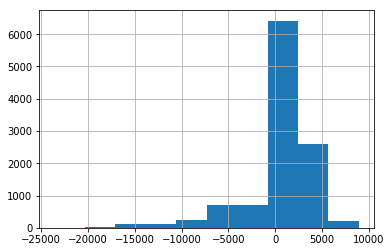

In [78]:
# the distribution of the last transaction amount.
%matplotlib inline
clean_data.groupby('contract_id').last()['Amount'].hist()

From the histogram of the last transaction amount for each contract_id, there are quite a few negative values and a lot of 0s. We can have a closer look by the payment_raio of these last payments.

In [79]:
clean_data.groupby('contract_id').last()['payment_ratio'].value_counts()

 1.00    7766
-3.00    1835
 1.05     798
 1.10     315
 0.00     197
 1.20     130
-1.00     111
 1.50      13
Name: payment_ratio, dtype: int64

From the definition of penalty_factor, when amount is 0, the payment_ratio will be 0; When amount is negative, the penalty_factor will be negative. For now I focus on the cases when penalty_factor equals 0, -1 and -3.  The analysis of these negative penalty_factor will expose the two different types of evictions.

### 9.1 one excessive long-delay type

penalty_factor = 0 implies the situation where tenants have no deposit left (indicating he has  missed one payment for at least two months) and eviction decision is given. After another month no deposit are returned. Let us have a look at one example.

In [80]:
clean_data[clean_data['payment_ratio'] == 0].head(3)

,contract_id,postcode,rent,contract_start,contract_end,id,contract_length,Payment_date,Amount,payment_method,transaction_length,payment_ratio,due_date,overdue_days
1037,1392083217,IG4 5AG,1250.0,2014-02-11,2015-09-10,Aaron Hudson 1965-06-29,576 days,2015-09-10,0.0,DIRECT_DEBIT,283,0.0,2015-08-11,30.0
1435,1383096745,EC1N2TT,1890.0,2013-10-30,2017-03-29,Aaryan Johnson 1964-06-24,1246 days,2017-03-29,0.0,DIRECT_DEBIT,849,0.0,2017-02-28,29.0
7674,1362796116,DA6 7WY,770.0,2013-03-09,2017-04-08,Alba Stevenson 1983-03-02,1491 days,2017-04-08,0.0,CASH,859,0.0,2017-03-09,30.0


In [81]:
clean_data[clean_data['id'] == 'Eliza Ford 1988-12-11'].tail(5)

,contract_id,postcode,rent,contract_start,contract_end,id,contract_length,Payment_date,Amount,payment_method,transaction_length,payment_ratio,due_date,overdue_days
69877,1343004890,W1A 7PT,2410.0,2012-07-23,2016-02-22,Eliza Ford 1988-12-11,1309 days,2015-10-03,2651.0,DIRECT_DEBIT,448,1.1,2015-09-23,10.0
69878,1343004890,W1A 7PT,2410.0,2012-07-23,2016-02-22,Eliza Ford 1988-12-11,1309 days,2015-11-20,2892.0,DIRECT_DEBIT,448,1.2,2015-10-23,28.0
69879,1343004890,W1A 7PT,2410.0,2012-07-23,2016-02-22,Eliza Ford 1988-12-11,1309 days,NaT,NaN,DIRECT_DEBIT,448,NaN,2015-11-23,NaN
69880,1343004890,W1A 7PT,2410.0,2012-07-23,2016-02-22,Eliza Ford 1988-12-11,1309 days,2016-01-23,NaN,DIRECT_DEBIT,448,NaN,2015-12-23,31.0
69881,1343004890,W1A 7PT,2410.0,2012-07-23,2016-02-22,Eliza Ford 1988-12-11,1309 days,2016-02-22,0.0,DIRECT_DEBIT,448,0.0,2016-01-23,30.0


Tenant Eliza Ford, who was born at 1988-12-11, has payment amount NaN at due date 2015-12-23 and 2016-01-23. Then on 2016-02-22 his contract is terminated and no deposit is returned. It is therefore reasonable to assume that NaN represents that he has missed his payment for these two due dates. And because of a single excessively long dealy, he was given eviction notice on 2016-01-23. By this timestamp, he has delayed his payment due at 2016-12-23 for at least 2 months.

### 9.2 two consecutive long-delay type

payment_ratio = -1 implies the situation where tenants have 1-month deposit left (indicating he has missed 1 payment for at least two month) and are evicted and returned 1-month deposit. 
Let us have a look at one example.

In [82]:
clean_data[clean_data['payment_ratio'] == -1].head(3)

,contract_id,postcode,rent,contract_start,contract_end,id,contract_length,Payment_date,Amount,payment_method,transaction_length,payment_ratio,due_date,overdue_days
1083,1410399486,SE109WQ,1190.0,2014-09-11,2017-06-10,Aaron Lloyd 1989-08-20,1003 days,2017-06-10,-1190.0,BANK_TRANSFER,922,-1.0,2017-05-11,30.0
2417,1455158675,W1J 9TB,4460.0,2016-02-11,2017-03-10,Abel Wood 1954-05-02,393 days,2017-03-10,-4460.0,DIRECT_DEBIT,393,-1.0,2017-02-11,27.0
2990,1377558355,HA3 8LN,1030.0,2013-08-27,2017-12-26,Abigail Hobbs 1977-12-26,1582 days,2017-12-26,-1030.0,DIRECT_DEBIT,1121,-1.0,2017-11-27,29.0


In [83]:
clean_data[clean_data['id'] == 'Amelia-Mae Cole 1990-01-04'].tail(5)

,contract_id,postcode,rent,contract_start,contract_end,id,contract_length,Payment_date,Amount,payment_method,transaction_length,payment_ratio,due_date,overdue_days
18764,1345853912,UB3 1PG,1070.0,2012-08-25,2015-08-24,Amelia-Mae Cole 1990-01-04,1094 days,2015-03-29,1123.5,DIRECT_DEBIT,266,1.05,2015-03-25,4.0
18765,1345853912,UB3 1PG,1070.0,2012-08-25,2015-08-24,Amelia-Mae Cole 1990-01-04,1094 days,2015-05-02,1123.5,DIRECT_DEBIT,266,1.05,2015-04-25,7.0
18766,1345853912,UB3 1PG,1070.0,2012-08-25,2015-08-24,Amelia-Mae Cole 1990-01-04,1094 days,2015-07-07,1605.0,DIRECT_DEBIT,266,1.50,2015-05-25,43.0
18767,1345853912,UB3 1PG,1070.0,2012-08-25,2015-08-24,Amelia-Mae Cole 1990-01-04,1094 days,2015-07-25,NaN,DIRECT_DEBIT,266,NaN,2015-06-25,30.0
18768,1345853912,UB3 1PG,1070.0,2012-08-25,2015-08-24,Amelia-Mae Cole 1990-01-04,1094 days,2015-08-24,-1070.0,DIRECT_DEBIT,266,-1.00,2015-07-25,30.0


Tenant Amelia-Mae Cole, who was born at 1990-01-04, has delayed his payment due at 2015-05-25 for 43 days, then he missed his payment due at 2015-06-25. On 2016-07-25, he has missed his payment for at least one month that is due at 2015-06-25, Because of the consecutive long delays, the eviction notice was given on 2016-07-25. The contract terminates at 2015-08-24 with one month deposit returned.

### 9.3 non-evicted type

payment_ratio = -3 implies the three month deposit is returned to the tenant and no eviction notice is given. We can check the implication from two examples as well. 

In [84]:
clean_data[clean_data['payment_ratio'] == -3].head(3)

,contract_id,postcode,rent,contract_start,contract_end,id,contract_length,Payment_date,Amount,payment_method,transaction_length,payment_ratio,due_date,overdue_days
68,1401145759,W1A 4LN,4660.0,2014-05-27,2017-06-26,Aadheen Davies 1983-01-06,1126 days,2017-06-26,-13980.0,DIRECT_DEBIT,938,-3.0,2017-06-27,-1.0
127,1441411266,SE116YQ,1830.0,2015-09-05,2016-11-04,Aaliah Jones 1992-08-13,426 days,2016-11-04,-5490.0,DIRECT_DEBIT,426,-3.0,2016-11-05,-1.0
141,1478307667,TW2 5AE,1300.0,2016-11-05,2017-12-04,Aaliah Jones 1992-08-13,394 days,2017-12-04,-3900.0,DIRECT_DEBIT,426,-3.0,2017-12-05,-1.0


In [85]:
clean_data[clean_data['id'] == 'Aaliah Jones 1992-08-13'].tail(3)

,contract_id,postcode,rent,contract_start,contract_end,id,contract_length,Payment_date,Amount,payment_method,transaction_length,payment_ratio,due_date,overdue_days
139,1478307667,TW2 5AE,1300.0,2016-11-05,2017-12-04,Aaliah Jones 1992-08-13,394 days,2017-10-06,1300.0,DIRECT_DEBIT,426,1.0,2017-10-05,1.0
140,1478307667,TW2 5AE,1300.0,2016-11-05,2017-12-04,Aaliah Jones 1992-08-13,394 days,2017-11-05,1300.0,DIRECT_DEBIT,426,1.0,2017-11-05,0.0
141,1478307667,TW2 5AE,1300.0,2016-11-05,2017-12-04,Aaliah Jones 1992-08-13,394 days,2017-12-04,-3900.0,DIRECT_DEBIT,426,-3.0,2017-12-05,-1.0


Tenant Aaliah Jones, who was born at 1992-08-13, didn't delay his payment in the last five due dates. And when the contract finished, the three month deposit is returned to him.

### 10. How many evictions, per type, are there?

### 10.1 preliminary analysis on one excessively long-delay type

We have seen from an example of excessive long delay. Now I am going to prove that all tenants who have their last row of a contract as 0 (no deposit returned) are at least three months delayed and are evicted.

In [86]:
excess_evict_id = clean_data[clean_data['payment_ratio'] == 0]['contract_id']

In [87]:
excess_evict_data = clean_data[clean_data['contract_id'].isin(excess_evict_id)]

In [88]:
excess_evict_data.shape

(3207, 14)

In [89]:
def check_excessive_long_func(df, last=1):
    return np.isnan(df.Amount.iloc[-(2+last)]) and np.isnan(df.Amount.iloc[-(1+last)])

In [90]:
# total number of contracts with amounts == 0 at the contract end
print(excess_evict_data['contract_id'].nunique())
# for all these contracts, the number of contracts whose two rows to the last are all Nan
sum(excess_evict_data.groupby('contract_id').apply(check_excessive_long_func))

197


197

All contracts with payment_ratio ends at 0 belong to excessive one long delay type. However, as I will show in Section 10.3, there are still a few contracts to be added to this type.

### 10.2 preliminary analysis on two consective long-delay type

We have assumed that for payment_ratio = -1, the tenant has two consecutive long delays.

Specifically, the first long delay should be over 1 month, and the second long delay should be over 2 months (1 NA value).

In [91]:
consec_evict_id = clean_data[clean_data['payment_ratio'] == -1]['contract_id']
consec_evict_data = clean_data[clean_data['contract_id'].isin(consec_evict_id)]

In [92]:
consec_evict_data.shape

(1942, 14)

In [93]:
def check_two_consec_func(df):
    return df['overdue_days'].iloc[-3] > 30 and np.isnan(df['Amount'].iloc[-2])

In [94]:
print(consec_evict_id.nunique())
sum(consec_evict_data.groupby('contract_id').apply(check_two_consec_func))

111


109

It seems there are two contract_ids vilaoting the assumption, lets have a closer look at the two cases.

In [95]:
idx = consec_evict_data.groupby('contract_id').apply(check_two_consec_func)
contract_id_false = idx[~idx].index

In [96]:
consec_evict_data[consec_evict_data['contract_id'].isin(contract_id_false)].groupby('contract_id').tail(3)

,contract_id,postcode,rent,contract_start,contract_end,id,contract_length,Payment_date,Amount,payment_method,transaction_length,payment_ratio,due_date,overdue_days
64174,1364690001,W2 4QP,1400.0,2013-03-31,2017-04-29,Diyan Ali 1989-04-07,1490 days,2017-03-01,1680.0,DIRECT_DEBIT,880,1.2,2017-01-31,29.0
64175,1364690001,W2 4QP,1400.0,2013-03-31,2017-04-29,Diyan Ali 1989-04-07,1490 days,2017-03-31,NaN,DIRECT_DEBIT,880,NaN,2017-02-28,31.0
64176,1364690001,W2 4QP,1400.0,2013-03-31,2017-04-29,Diyan Ali 1989-04-07,1490 days,2017-04-29,-1400.0,DIRECT_DEBIT,880,-1.0,2017-03-31,29.0
171260,1361839592,N12 8RR,1530.0,2013-02-26,2016-09-25,Luke Kirby 1982-04-28,1307 days,2016-07-26,1836.0,DIRECT_DEBIT,664,1.2,2016-06-26,30.0
171261,1361839592,N12 8RR,1530.0,2013-02-26,2016-09-25,Luke Kirby 1982-04-28,1307 days,2016-08-26,NaN,DIRECT_DEBIT,664,NaN,2016-07-26,31.0
171262,1361839592,N12 8RR,1530.0,2013-02-26,2016-09-25,Luke Kirby 1982-04-28,1307 days,2016-09-25,-1530.0,DIRECT_DEBIT,664,-1.0,2016-08-26,30.0


We can see that although their last to bottom payment has also very long overdue_days (one with 29 overdue days and one with 30 overdue days). Therefore we can change our articulation of this eviction type as **tenant has two consecutive long delays (first nearly or above 1 month and second two months)**

In [97]:
consec_evict_data['contract_id'].nunique()

111

There are 111 evictions belong to this type. But as 10.3 will show, there are a few to be added to this type.

### 10.3 further investigation and data cleaning

#### 10.3.1 final check on one excessively long-delay type

Are there any contract IDs that are evicted but not included?

In [98]:
# Let us check the rest data that are not inlcuded in the previous two subsections.
other_data = clean_data[np.logical_not(np.logical_or(clean_data['contract_id'].isin(consec_evict_id), clean_data['contract_id'].isin(excess_evict_id)))]

In [99]:
trouble_id = other_data.loc[other_data.Amount.isnull(), 'contract_id'].unique()
trouble_id

array([1450404450, 1495758461, 1331862491, 1494379265, 1424312077,
       1470271859, 1491096455])

As we can see, there are still seven cases that are evicted but not considered in the previous analysis. This is because their behaviour appears approaching the end of the sampling period (2017-12) and therefore the last row (returning the deposit) is not recorded in the sample and therefore should be also included in the two types discussed above.

In [100]:
trouble_data = other_data[other_data['contract_id'].isin(trouble_id)]
add_excess_evict_id = trouble_data.groupby('contract_id').apply(check_excessive_long_func, last=0)
add_excess_evict_id = add_excess_evict_id[add_excess_evict_id].index
add_excess_evict_data = trouble_data[trouble_data['contract_id'].isin(add_excess_evict_id)]
add_excess_evict_data.groupby('contract_id').tail(3)

,contract_id,postcode,rent,contract_start,contract_end,id,contract_length,Payment_date,Amount,payment_method,transaction_length,payment_ratio,due_date,overdue_days
66437,1450404450,IG8 0TJ,1230.0,2015-12-18,2017-12-18,Edith Walker 1993-01-31,731 days,2017-09-18,1230.0,BANK_TRANSFER,731,1.0,2017-09-18,0.0
66438,1450404450,IG8 0TJ,1230.0,2015-12-18,2017-12-18,Edith Walker 1993-01-31,731 days,NaT,NaN,BANK_TRANSFER,731,NaN,2017-10-18,NaN
66439,1450404450,IG8 0TJ,1230.0,2015-12-18,2017-12-18,Edith Walker 1993-01-31,731 days,2017-12-18,NaN,BANK_TRANSFER,731,NaN,2017-11-18,30.0
108225,1331862491,SW189DW,1720.0,2012-03-16,2017-12-16,Hope Hale 1972-07-26,2101 days,2017-09-16,1720.0,DIRECT_DEBIT,1111,1.0,2017-09-16,0.0
108226,1331862491,SW189DW,1720.0,2012-03-16,2017-12-16,Hope Hale 1972-07-26,2101 days,NaT,NaN,DIRECT_DEBIT,1111,NaN,2017-10-16,NaN
108227,1331862491,SW189DW,1720.0,2012-03-16,2017-12-16,Hope Hale 1972-07-26,2101 days,2017-12-16,NaN,DIRECT_DEBIT,1111,NaN,2017-11-16,30.0
126482,1494379265,E14 1BY,1130.0,2017-05-10,2017-12-10,Jamie Hunt 1990-03-31,214 days,2017-09-12,1130.0,CASH,214,1.0,2017-09-10,2.0
126483,1494379265,E14 1BY,1130.0,2017-05-10,2017-12-10,Jamie Hunt 1990-03-31,214 days,NaT,NaN,CASH,214,NaN,2017-10-10,NaN
126484,1494379265,E14 1BY,1130.0,2017-05-10,2017-12-10,Jamie Hunt 1990-03-31,214 days,2017-12-10,NaN,CASH,214,NaN,2017-11-10,30.0
157308,1470271859,IG111BA,1050.0,2016-08-04,2017-12-04,Leighton Wood 1961-10-18,487 days,2017-09-15,1155.0,DIRECT_DEBIT,487,1.1,2017-09-04,11.0


Tenant Leighton Wood, who was born at 1961-10-18, has delayed his payment due at 2017-10-04 for at least two months at 2017-12-24. So he is evicted.

In [101]:
excess_evict_data = pd.concat([excess_evict_data, add_excess_evict_data], ignore_index=True)
excess_evict_id = pd.concat([excess_evict_id, pd.Series(add_excess_evict_id)], ignore_index=True)
excess_evict_id.shape[0]

201

**Now we have four more cases belonging to excessive one long delay type.**

#### 10.3.2 cleaning one excessively long-delay type data

In [102]:
excess_evict_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3290 entries, 0 to 3289
Data columns (total 14 columns):
contract_id           3290 non-null int64
postcode              3290 non-null object
rent                  3290 non-null float64
contract_start        3290 non-null datetime64[ns]
contract_end          3290 non-null datetime64[ns]
id                    3290 non-null object
contract_length       3290 non-null timedelta64[ns]
Payment_date          3089 non-null datetime64[ns]
Amount                2888 non-null float64
payment_method        3290 non-null object
transaction_length    3290 non-null int64
payment_ratio         2888 non-null float64
due_date              3290 non-null datetime64[ns]
overdue_days          3089 non-null float64
dtypes: datetime64[ns](4), float64(4), int64(2), object(3), timedelta64[ns](1)
memory usage: 359.9+ KB


In [103]:
excess_evict_data.groupby('contract_id').tail(3).head(20)

,contract_id,postcode,rent,contract_start,contract_end,id,contract_length,Payment_date,Amount,payment_method,transaction_length,payment_ratio,due_date,overdue_days
6,1392083217,IG4 5AG,1250.0,2014-02-11,2015-09-10,Aaron Hudson 1965-06-29,576 days,NaT,NaN,DIRECT_DEBIT,283,NaN,2015-06-11,NaN
7,1392083217,IG4 5AG,1250.0,2014-02-11,2015-09-10,Aaron Hudson 1965-06-29,576 days,2015-08-11,NaN,DIRECT_DEBIT,283,NaN,2015-07-11,31.0
8,1392083217,IG4 5AG,1250.0,2014-02-11,2015-09-10,Aaron Hudson 1965-06-29,576 days,2015-09-10,0.0,DIRECT_DEBIT,283,0.0,2015-08-11,30.0
33,1383096745,EC1N2TT,1890.0,2013-10-30,2017-03-29,Aaryan Johnson 1964-06-24,1246 days,NaT,NaN,DIRECT_DEBIT,849,NaN,2016-12-30,NaN
34,1383096745,EC1N2TT,1890.0,2013-10-30,2017-03-29,Aaryan Johnson 1964-06-24,1246 days,2017-02-28,NaN,DIRECT_DEBIT,849,NaN,2017-01-30,29.0
35,1383096745,EC1N2TT,1890.0,2013-10-30,2017-03-29,Aaryan Johnson 1964-06-24,1246 days,2017-03-29,0.0,DIRECT_DEBIT,849,0.0,2017-02-28,29.0
61,1362796116,DA6 7WY,770.0,2013-03-09,2017-04-08,Alba Stevenson 1983-03-02,1491 days,NaT,NaN,CASH,859,NaN,2017-01-09,NaN
62,1362796116,DA6 7WY,770.0,2013-03-09,2017-04-08,Alba Stevenson 1983-03-02,1491 days,2017-03-09,NaN,CASH,859,NaN,2017-02-09,28.0
63,1362796116,DA6 7WY,770.0,2013-03-09,2017-04-08,Alba Stevenson 1983-03-02,1491 days,2017-04-08,0.0,CASH,859,0.0,2017-03-09,30.0
92,1353034842,SW4 7NQ,2410.0,2012-11-16,2017-07-15,Albert Ali 1986-10-20,1702 days,NaT,NaN,CASH,957,NaN,2017-04-16,NaN


As we can see from the above table, there are still many missing values for some key variables, id. Payment_date, overdue_day and payment_ratio. Now we want to clean this dataset. 

In [104]:
def clean_excess_long_func(df):
    df.loc[df.Payment_date.isnull(), 'payment_ratio'] = 1.5
    df.loc[df.Payment_date.isnull(), 'overdue_days'] = 31
    # and update the penalty_factor for the second NA amount row to 1 as it indicates at least two month delay
    df.loc[np.logical_and(df.Payment_date.notnull(), df.Amount.isnull()), 'payment_ratio'] = 2
    # update the overdue_days value for the second NA amount rows to 62 as it reflects two month delays
    df.loc[np.logical_and(df.Payment_date.notnull(), df.Amount.isnull()), 'overdue_days'] = 62
    df.loc[df.Payment_date.isnull(), 'Payment_date'] = df.loc[np.logical_and(df.Payment_date.notnull(), df.Amount.isnull()), 'due_date'].values
    return df
excess_evict_data = excess_evict_data.groupby('contract_id').apply(clean_excess_long_func)
# last row when Amount == 0 is deleted because the eviction decision is made prior to this date.
excess_evict_data = excess_evict_data[excess_evict_data['payment_ratio'] != 0]
# create an evicted variable to mark what kind of eviction it is
excess_evict_data['evicted'] = 1

In [105]:
excess_evict_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3093 entries, 0 to 3289
Data columns (total 15 columns):
contract_id           3093 non-null int64
postcode              3093 non-null object
rent                  3093 non-null float64
contract_start        3093 non-null datetime64[ns]
contract_end          3093 non-null datetime64[ns]
id                    3093 non-null object
contract_length       3093 non-null timedelta64[ns]
Payment_date          3093 non-null datetime64[ns]
Amount                2691 non-null float64
payment_method        3093 non-null object
transaction_length    3093 non-null int64
payment_ratio         3093 non-null float64
due_date              3093 non-null datetime64[ns]
overdue_days          3093 non-null float64
evicted               3093 non-null int64
dtypes: datetime64[ns](4), float64(4), int64(3), object(3), timedelta64[ns](1)
memory usage: 386.6+ KB


#### 10.3.3 final check on two consecutively long-delay type

In [106]:
# the rest is the consec_id 
add_consec_evict_id = trouble_data.loc[~trouble_data['contract_id'].isin(add_excess_evict_id), 'contract_id'].unique()
add_consec_evict_data = other_data[other_data['contract_id'].isin(add_consec_evict_id)]
add_consec_evict_data.groupby('contract_id').tail(3).head(5)

,contract_id,postcode,rent,contract_start,contract_end,id,contract_length,Payment_date,Amount,payment_method,transaction_length,payment_ratio,due_date,overdue_days
101073,1495758461,E16 1QL,1560.0,2017-05-26,2017-12-26,Harry Akhtar 1970-08-01,214 days,2017-10-13,1872.0,DIRECT_DEBIT,214,1.2,2017-09-26,17.0
101074,1495758461,E16 1QL,1560.0,2017-05-26,2017-12-26,Harry Akhtar 1970-08-01,214 days,2017-12-02,2340.0,DIRECT_DEBIT,214,1.5,2017-10-26,37.0
101075,1495758461,E16 1QL,1560.0,2017-05-26,2017-12-26,Harry Akhtar 1970-08-01,214 days,2017-12-26,NaN,DIRECT_DEBIT,214,NaN,2017-11-26,30.0
132883,1424312077,NW9 9ET,1750.0,2015-02-19,2017-12-19,Jessica Quinn 1974-07-27,1034 days,2017-09-19,1750.0,DIRECT_DEBIT,1034,1.0,2017-09-19,0.0
132884,1424312077,NW9 9ET,1750.0,2015-02-19,2017-12-19,Jessica Quinn 1974-07-27,1034 days,2017-11-23,2625.0,DIRECT_DEBIT,1034,1.5,2017-10-19,35.0


Tenant Harry Akhtar, who was born at 1970-08-01, has delayed his payment for 37 days due at 2017-10-26. He then missed his payment due at 2017-11-26. Therefore, he should be classified into the two consecutive long-delay type.

In [107]:
consec_evict_data = pd.concat([consec_evict_data, add_consec_evict_data], ignore_index=True)
consec_evict_id = pd.concat([consec_evict_id, pd.Series(add_consec_evict_id)], ignore_index=True)
consec_evict_data['contract_id'].nunique()

114

**Now we have three more cases belonging to two consecutive long-delay type**

#### 10.3.4 cleaning two consecutive long-delay type data

In [108]:
consec_evict_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1991 entries, 0 to 1990
Data columns (total 14 columns):
contract_id           1991 non-null int64
postcode              1991 non-null object
rent                  1991 non-null float64
contract_start        1991 non-null datetime64[ns]
contract_end          1991 non-null datetime64[ns]
id                    1991 non-null object
contract_length       1991 non-null timedelta64[ns]
Payment_date          1991 non-null datetime64[ns]
Amount                1877 non-null float64
payment_method        1991 non-null object
transaction_length    1991 non-null int64
payment_ratio         1877 non-null float64
due_date              1991 non-null datetime64[ns]
overdue_days          1991 non-null float64
dtypes: datetime64[ns](4), float64(4), int64(2), object(3), timedelta64[ns](1)
memory usage: 217.8+ KB


payment_ratio has missing values and we have to deal with it.

In [109]:
consec_evict_data.groupby('contract_id').tail(3).head(6)

,contract_id,postcode,rent,contract_start,contract_end,id,contract_length,Payment_date,Amount,payment_method,transaction_length,payment_ratio,due_date,overdue_days
27,1410399486,SE109WQ,1190.0,2014-09-11,2017-06-10,Aaron Lloyd 1989-08-20,1003 days,2017-05-10,1785.0,BANK_TRANSFER,922,1.5,2017-03-11,60.0
28,1410399486,SE109WQ,1190.0,2014-09-11,2017-06-10,Aaron Lloyd 1989-08-20,1003 days,2017-05-11,NaN,BANK_TRANSFER,922,NaN,2017-04-11,30.0
29,1410399486,SE109WQ,1190.0,2014-09-11,2017-06-10,Aaron Lloyd 1989-08-20,1003 days,2017-06-10,-1190.0,BANK_TRANSFER,922,-1.0,2017-05-11,30.0
40,1455158675,W1J 9TB,4460.0,2016-02-11,2017-03-10,Abel Wood 1954-05-02,393 days,2017-01-20,6690.0,DIRECT_DEBIT,393,1.5,2016-12-11,40.0
41,1455158675,W1J 9TB,4460.0,2016-02-11,2017-03-10,Abel Wood 1954-05-02,393 days,2017-02-11,NaN,DIRECT_DEBIT,393,NaN,2017-01-11,31.0
42,1455158675,W1J 9TB,4460.0,2016-02-11,2017-03-10,Abel Wood 1954-05-02,393 days,2017-03-10,-4460.0,DIRECT_DEBIT,393,-1.0,2017-02-11,27.0


In [110]:
# fill in the payment_ratio for the NA amount rows to 1.5 as it indicates at least one month delay
consec_evict_data['payment_ratio'].fillna(1.5, inplace=True)
# update the overdue_days value for the NA amount rows to 31 as it matches the payment_ratio
consec_evict_data.loc[consec_evict_data.Amount.isnull(), 'overdue_days'] = 31
# drop rows where the amount < 0 as evict decision made prior to this date
consec_evict_data = consec_evict_data[consec_evict_data['payment_ratio'] != -1]
# create a evicted variable to mark whether their evicted or what kind of eviction
consec_evict_data['evicted'] = 2

In [111]:
consec_evict_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1880 entries, 0 to 1990
Data columns (total 15 columns):
contract_id           1880 non-null int64
postcode              1880 non-null object
rent                  1880 non-null float64
contract_start        1880 non-null datetime64[ns]
contract_end          1880 non-null datetime64[ns]
id                    1880 non-null object
contract_length       1880 non-null timedelta64[ns]
Payment_date          1880 non-null datetime64[ns]
Amount                1766 non-null float64
payment_method        1880 non-null object
transaction_length    1880 non-null int64
payment_ratio         1880 non-null float64
due_date              1880 non-null datetime64[ns]
overdue_days          1880 non-null float64
evicted               1880 non-null int64
dtypes: datetime64[ns](4), float64(4), int64(3), object(3), timedelta64[ns](1)
memory usage: 235.0+ KB


There is no missing values now.

#### 10.3.5 cleaning non-evict data

In [112]:
non_evict_data = clean_data[np.logical_not(np.logical_or(clean_data['contract_id'].isin(consec_evict_id), clean_data['contract_id'].isin(excess_evict_id)))]

In [113]:
non_evict_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257274 entries, 0 to 262554
Data columns (total 14 columns):
contract_id           257274 non-null int64
postcode              257274 non-null object
rent                  257274 non-null float64
contract_start        257274 non-null datetime64[ns]
contract_end          257274 non-null datetime64[ns]
id                    257274 non-null object
contract_length       257274 non-null timedelta64[ns]
Payment_date          257274 non-null datetime64[ns]
Amount                257274 non-null float64
payment_method        257274 non-null object
transaction_length    257274 non-null int64
payment_ratio         257274 non-null float64
due_date              257274 non-null datetime64[ns]
overdue_days          257274 non-null float64
dtypes: datetime64[ns](4), float64(4), int64(2), object(3), timedelta64[ns](1)
memory usage: 29.4+ MB


In [114]:
non_evict_data = non_evict_data[non_evict_data['payment_ratio'] != -3]
# create a variable evicted and let them mark they are not evicted
non_evict_data['evicted'] = 0

In [115]:
non_evict_data['payment_ratio'].value_counts()

1.00    218539
1.05     21897
1.10      8994
1.20      5012
1.50       997
Name: payment_ratio, dtype: int64

In [116]:
non_evict_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255439 entries, 0 to 262554
Data columns (total 15 columns):
contract_id           255439 non-null int64
postcode              255439 non-null object
rent                  255439 non-null float64
contract_start        255439 non-null datetime64[ns]
contract_end          255439 non-null datetime64[ns]
id                    255439 non-null object
contract_length       255439 non-null timedelta64[ns]
Payment_date          255439 non-null datetime64[ns]
Amount                255439 non-null float64
payment_method        255439 non-null object
transaction_length    255439 non-null int64
payment_ratio         255439 non-null float64
due_date              255439 non-null datetime64[ns]
overdue_days          255439 non-null float64
evicted               255439 non-null int64
dtypes: datetime64[ns](4), float64(4), int64(3), object(3), timedelta64[ns](1)
memory usage: 31.2+ MB


Finally, we have a clean dataset where all non-evicted contracts are recorded.

In [117]:
non_evict_data['contract_id'].nunique()

10850

**In summary, out of 11165 contracts, 10850 contracts belong to non-evicted type; 
201 contracts belong to one excessive long-delay evicted type; 
114 belong to two conseuctive long-delay evicted type**

In [118]:
evict_data = pd.concat([consec_evict_data, excess_evict_data], ignore_index=True)

In [119]:
final_data = pd.concat([excess_evict_data, consec_evict_data, non_evict_data], ignore_index=True)

In [121]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260412 entries, 0 to 260411
Data columns (total 15 columns):
contract_id           260412 non-null int64
postcode              260412 non-null object
rent                  260412 non-null float64
contract_start        260412 non-null datetime64[ns]
contract_end          260412 non-null datetime64[ns]
id                    260412 non-null object
contract_length       260412 non-null timedelta64[ns]
Payment_date          260412 non-null datetime64[ns]
Amount                259896 non-null float64
payment_method        260412 non-null object
transaction_length    260412 non-null int64
payment_ratio         260412 non-null float64
due_date              260412 non-null datetime64[ns]
overdue_days          260412 non-null float64
evicted               260412 non-null int64
dtypes: datetime64[ns](4), float64(4), int64(3), object(3), timedelta64[ns](1)
memory usage: 29.8+ MB


Except for contract_end and Amount, there is no missing values now. 

Before moving on to the modelling part, we can inspect the difference in overdue days between evicted and non-evicted.

In [123]:
evict_overdue_stats = evict_data.groupby('contract_id')['overdue_days'].agg(['mean', 'max', 'sum'])

evict_overdue_stats.agg('mean')

mean     15.915090
max      55.377778
sum     214.730159
dtype: float64

In [124]:
non_evict_stats = non_evict_data.groupby('contract_id')['overdue_days'].agg(['mean', 'max', 'sum'])

non_evict_stats.agg('mean')

mean     1.415587
max      6.897604
sum     34.220829
dtype: float64

Here, mean is the overall mean of overdue days for all evicted, max is the mean of the maximum overdue days across contract ID. sum is the average of summed-up overdue days across contract ID.


**As we can tell from the comparison, the evicted has far larger overdue days in terms of all three statistics than non-evicted.**

In [125]:
final_data['contract_id'].nunique()

11165

In [126]:
# after combining the three datasets, sort them in the order of id, contract_start, due_date
# because our later on modelling practice require timestamp following a time order.
final_data.sort_values(['id', 'contract_start', 'due_date'], inplace=True)

In [127]:
final_data.to_csv('final_data.csv', index = False)